# PSF Check

In [1]:
from gammapy.cube import PSFMap
from gammapy.irf import EnergyDependentTablePSF

In [230]:
from pathlib import Path

from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.maps.profile import ImageProfile, ImageProfileEstimator
from gammapy.irf import EnergyDispersion2D, PSF3D, EnergyDependentMultiGaussPSF, load_cta_irfs

from gammapy.cube import (
    MapDataset,
    MapDatasetEventSampler,
    MapDatasetMaker,
)
from gammapy.utils.random import get_random_state


In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import astropy.units as u


In [4]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


In [5]:
def gaussian(x, amp, wid):
    return amp * np.exp(-(x)**2 / (2*wid**2.))


In [6]:
BASE_PATH = Path("../make.py").parent

In [7]:
model = "point-pwlsimple"
filename_model = BASE_PATH / f"models/{model}.yaml"


In [343]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(0.15, 0.15), binsz=0.01, frame="galactic", axes=[ENERGY_AXIS]
)


### Create the dataset

In [182]:
# spatial_model = PointSpatialModel(lon_0="0.0deg", lat_0="0.0deg", frame="galactic")
# spectral_model = PowerLawSpectralModel(amplitude="1e-11 cm-2 s-1 TeV-1")
# skymodel = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

# #Now we create a reference exposure map, we use to evaluate the model:
# position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')

# energy_axis = MapAxis.from_bounds(1, 100, nbin=30, unit="TeV", name="energy", interp="log")

# exposure = Map.create(
#     binsz=0.02,
#     map_type='wcs',
#     skydir=position,
#     width="5 deg",
#     axes=[energy_axis],
#     frame="galactic", unit="cm2 s"
# )

# exposure.data = 1e10 * 1000 * np.ones(exposure.data.shape)

# evaluator = MapDataset.create(WCS_GEOM, models=skymodel, exposure=exposure)

# npred = evaluator.compute_npred()
# n_events = self.random_state.poisson(np.sum(npred.data))

In [183]:
# evaluator.exposure=exposure

In [184]:
# npred = evaluator.npred()

In [185]:
# random_state = get_random_state(0)
# n_events = random_state.poisson(np.sum(npred.data))
# coords = npred.sample_coord(n_events, random_state)

In [186]:
# npred.data
# n_events
# coords['energy']

In [390]:
irfs = load_cta_irfs(IRF_FILE)

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure"])
dataset = maker.run(empty, observation)

In [346]:
models = Models.read(filename_model)
dataset.models = models

In [348]:
evaluator=dataset._evaluators[0]
npred = evaluator.compute_npred()

In [470]:
a=npred.sum_over_axes()

#### Simulate the events

In [391]:
random_state = get_random_state(0)
n_events = random_state.poisson(np.sum(npred.data))
coords = npred.sample_coord(n_events, random_state)

In [350]:
coord = SkyCoord(coords['lon'], coords['lat'], frame='galactic')

In [351]:
ra,dec = coord.icrs.ra.value,coord.icrs.dec.value 

#### Pointlike source distribution

In [389]:
model = PointSpatialModel(lon_0="0.01deg", lat_0="0.01deg", frame="galactic",)

width=0.15
bins=0.01
geom = WcsGeom.create(
    skydir=SkyCoord("0.0d 0.0d", frame="galactic"), width=(width, width), binsz=bins
)

#### Compare the 2Dhistograms

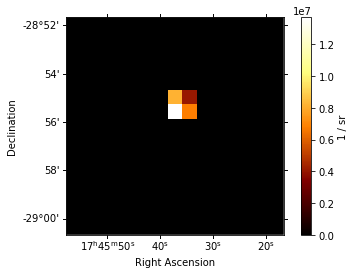

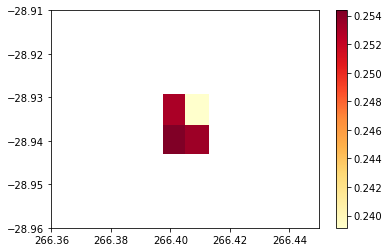

In [386]:
#plot the point source
model.plot(geom=geom, add_cbar=True)

#plot the npred histogram
plt.subplots(1,1)
weights = np.ones_like(ra)/float(len(ra))
plt.hist2d(ra,dec, bins=2, 
           cmap=plt.cm.YlOrRd, weights=weights,
          )
plt.xlim(266.36,266.45)
plt.ylim(-28.96,-28.91)
plt.colorbar()

In [ ]:
fig,ax=plt.subplots(1,1)
ax = model.plot(geom=geom, add_cbar=True)

fig,ax=plt.subplots(1,1)
weights = np.ones_like(ra)/float(len(ra))
ax.hist2d(ra,dec, bins=2, 
           cmap=plt.cm.YlOrRd, weights=weights,
          )
ax.set_xlim(266.36,266.45)
ax.set_ylim(-28.96,-28.91)
# fig.colorbar(axs[1], ax=fig)

### Create a fake PSF

In [496]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
psf_gauss.sigmas[0] = (psf_gauss.sigmas[0] / psf_gauss.sigmas[0]) * 0.1
psf_gauss.norms[0][:] = 1
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

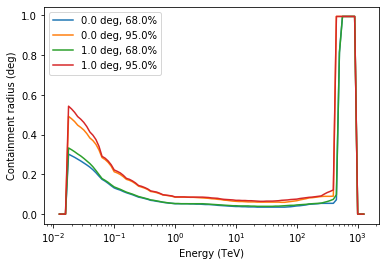

In [490]:
psf_3d.plot_containment_vs_energy()

##### Create the dataset

In [419]:
irfs = load_cta_irfs(IRF_FILE)

irfs['psf'] = psf_3d

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME*10, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure", "psf"])
dataset = maker.run(empty, observation)

##### Simulate the events

In [420]:
models = Models.read(filename_model)
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)

In [421]:
tab=events.table['RA','DEC','ENERGY']

In [422]:
events.table = tab

In [423]:
# events.table

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1321eb320>)

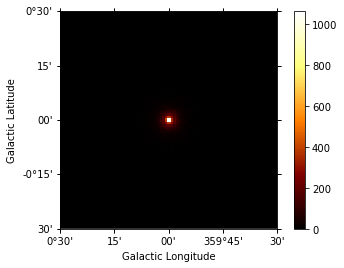

In [424]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.01, npix=(100, 100))
counts.fill_events(events)
counts.plot(add_cbar=True)

In [425]:
p = ImageProfileEstimator(method='sum', axis='radial', center=POINTING)
profile = p.run(counts)

In [426]:
dr = (profile.table['x_max']-profile.table['x_min'])
x = profile.table['x_ref']
y = profile.table['profile']*2*np.pi*x*dr
yerr = np.where(y<=0, 1e6, y**0.5) #not correctly estimated...

In [427]:
init_vals = [6, 0.1]
best_vals, covar = curve_fit(gaussian, x[2:], 
                             (y[2:]), 
                             p0=init_vals, 
                             sigma=yerr[2:])

print("############")
print(f"This is the normalization: {best_vals[0]} +\- {covar[0,0]**0.5}")
print(f"This is the sigma: {best_vals[1]} +\- {covar[1,1]**0.5}")
print("############")

############
This is the normalization: 4.500840148098383 +\- 0.17009497129360698
This is the sigma: 0.1257570454227987 +\- 0.0027958918115839333
############


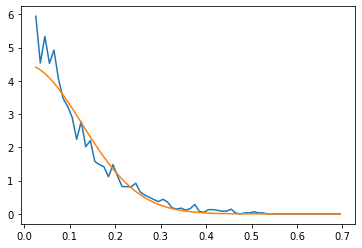

In [429]:
plt.plot(x[2:], y[2:])
plt.plot(x[2:], gaussian(x[2:],*best_vals))
plt.show()

#### Check sample_psf_coord()

In [282]:
table = Table()

In [283]:
n_events = int(len(events.table))
table['RA_TRUE'] = np.ones(n_events)*266.40498829 * u.deg
table['DEC_TRUE'] = np.ones(n_events)*-28.93617776 * u.deg
table['ENERGY_TRUE'] = events.table['ENERGY_TRUE']
table = EventList(table)

In [284]:
sampler = MapDatasetEventSampler(random_state=0)
evt_psf_mod = sampler.sample_psf(dataset.psf, table)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12d143f60>)

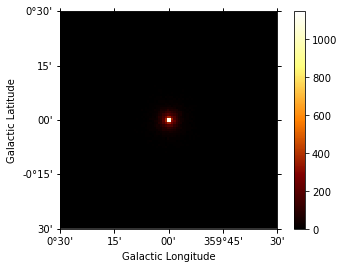

In [285]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.01, npix=(100, 100))
counts.fill_events(evt_psf_mod)
counts.plot(add_cbar=True)

In [338]:
p = ImageProfileEstimator(method='sum', axis='radial', center=POINTING)
profile = p.run(counts)

In [339]:
index = np.where(profile.table['profile']>0)
dr = (profile.table['x_max']-profile.table['x_min'])[index]
x = profile.table['x_ref'][index]
y = profile.table['profile'][index]*2*np.pi*x*dr
yerr = y**0.5

In [340]:
init_vals = [6, 0.1]
best_vals, covar = curve_fit(gaussian, x[2:], 
                             (y[2:]), 
                             p0=init_vals, 
                             sigma=yerr[2:])

print("############")
print(f"This is the normalization: {best_vals[0]} +\- {covar[0,0]**0.5}")
print(f"This is the sigma: {best_vals[1]} +\- {covar[1,1]**0.5}")
print("############")

############
This is the normalization: 4.536487704160845 +\- 0.21069241054066848
This is the sigma: 0.12255440957273175 +\- 0.003363419659192104
############


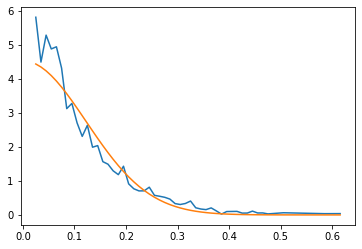

In [341]:
plt.plot(x[2:], y[2:])
plt.plot(x[2:], gaussian(x[2:],*best_vals))
plt.show()

#### Comparing 1D histograms

In [448]:
models = Models.read(filename_model)
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)

In [449]:
src_pos = SkyCoord(0.0*u.deg, 0.0*u.deg, frame='galactic')
evt_pos = SkyCoord(events.table['RA'], events.table['DEC'], frame='icrs')
evt_pos_psf_mod = SkyCoord(evt_psf_mod.table['RA'], evt_psf_mod.table['DEC'], frame='icrs')
sep = src_pos.separation(evt_pos).value
sep_other = src_pos.separation(evt_pos_psf_mod).value

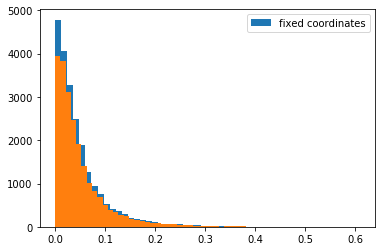

In [484]:
plt.hist(sep_other, bins=50, label='fixed coordinates')
plt.hist(sep, bins=50, label='')
# plt.plot(x[2:], gaussian(x[2:],5000,0.1))
plt.legend()

In [221]:
# model = PointSpatialModel(lon_0="0.0deg", lat_0="0.0 deg", frame="galactic",)

# bins=0.002
# width=0.1
# geom = WcsGeom.create(
#     skydir=SkyCoord("0d 0d", frame="galactic"), width=(width, width), binsz=bins
# )
# # model.plot(geom=geom, add_cbar=True)

In [222]:
# pnt_pos = geom.get_coord().skycoord

In [223]:
# pnt_pos = np.reshape(pnt_pos, (1,int(width/bins)**2))[0]

In [224]:
# pnt_sep = src_pos.separation(pnt_pos).value

In [225]:
# plt.hist(pnt_sep, bins=10)

In [226]:
# # do that with sample_psf_coord
# weights1 = np.ones_like(pnt_sep)/float(len(pnt_sep))
# weights2 = np.ones_like(sep)/float(len(sep))
# plt.hist(pnt_sep, bins=20, weights=weights1, label='point-like')
# plt.hist(sep, bins=20, weights=weights2, label='sim. events')
# plt.legend()
# # plt.hist(pnt_sep, bins=20)
# # plt.hist(sep, bins=20)
# # axs[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
# # axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))